Mount Google Drive and set the working directory

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Dashtoon_Assignment')

Mounted at /content/drive


Run the following code cell to import the necessary packages and dependencies needed to perform Neural Style Transfer.

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

Neural Style Transfer (NST) is one of the most interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S.

In [3]:
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

80134624/80134624 [==============================] - 0s 0us/step


## Neural Style Transfer (NST)

Next, we will be building the Neural Style Transfer (NST) algorithm in three steps:

- First, we will build the content cost function $J_{content}(C,G)$
- Second, we will build the style cost function $J_{style}(S,G)$
- Finally, we'll put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. Exciting!


### Computing the Content Cost


#### Make Generated Image G Match the Content of Image C

One goal we are aiming for when performing NST is for the content in generated image G to match the content of image C. To do so, we'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>.

#### To choose a "middle" activation layer $a^{[l]}$ :
We need the "generated" image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image.
* We will usually get the most visually pleasing results if we choose a layer from somewhere in the middle of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.


#### To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer we had chosen. This will be an $n_H \times n_W \times n_C$ tensor.

#### To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward propagation.
* Let $a^{(G)}$ be the corresponding hidden layer activation.

In this running example, the content image C will be the picture of a Persian Cat. Run the code below to see the picture.

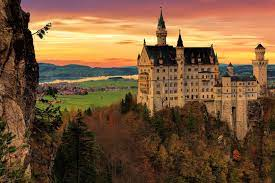

In [5]:
content_image = Image.open("content.jpg")
content_image

#### Content Cost Function $J_{content}(C,G)$
One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer we have chosen, and appear in a normalization term in the cost.
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations.
* In order to compute the cost $J_{content}(C,G)$, it will be convenient to unroll these 3D volumes into a 2D matrix, as shown below.

### compute_content_cost

Compute the "content cost" using TensorFlow.

`a_G`: hidden layer activations representing content of the image G
<br>
`a_C`: hidden layer activations representing content of the image C

The 3 steps in this function are:
1. Retrieve dimensions from `a_G`:
2. Unroll `a_C` and `a_G` as explained in the picture above
3. Compute the content cost

In [6]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that we compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]

    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape 'a_C' and 'a_G'
    a_C_unrolled = tf.reshape(a_C, shape=[_, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[_, -1, n_C])

    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))/(4*n_H*n_W*n_C)

    return J_content

<a name='4-2'></a>
### 4.2 - Computing the Style Cost

For the running example, we will use the following style image:

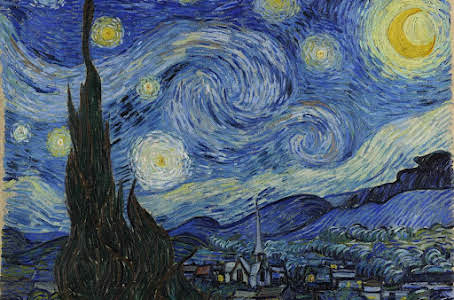

In [7]:
style_image = Image.open("style.jpg")
style_image

Defining a "style" cost function $J_{style}(S,G)$!

#### Style Matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix."
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$.



#### Compute Gram matrix $G_{gram}$
We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$.

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is.
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture.


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image.

### gram_matrix
* Using TensorFlow, this function computes the Gram matrix of a matrix A.
    * The formula is: The gram matrix of A is $G_A = AA^T$.

In [8]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    GA = tf.matmul(A, tf.transpose(A))

    return GA

#### Style Cost

Now we will minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G.
* For now, we will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.


### compute_layer_style_cost
Compute the style cost for a single layer.
The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G:
2. Unroll the hidden layer activations a_S and a_G into 2D matrices
3. Compute the Style matrix of the images S and G
4. Compute the Style cost

In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]), perm=[1,0])
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]), perm=[1,0])

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/(4*n_C*n_C*n_H*n_H*n_W*n_W)


    return J_style_layer

#### Style Weights

* So far we have captured the style from only one layer.
* We'll get better results if we "merge" style costs from several different layers.
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* By default, give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

Listing the layer names:

In [10]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Output the layer `block5_conv4`. This is the content layer, which will represent the image.

In [11]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Now we choose the layers to represent the style of the image and assign style costs:

In [12]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

We combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`.


### compute_style_cost
Compute style cost

#### Description of `compute_style_cost`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style)

Once it is done with the loop:  
* Return the overall style cost.

In [13]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if we want the generated image to softly follow the style image, we would choose larger weights for deeper layers and smaller weights for the first layers. In contrast, if we want the generated image to strongly follow the style image, we would choose smaller weights for deeper layers and larger weights for the first layers.
In this case we are choosing equal weights

### Defining the Total Cost to Optimize

Finally, we will create a cost function that minimizes both the style and the content cost. The formula is:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

### total_cost

Implementing the total cost function which includes both the content cost and the style cost.

In [14]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha*J_content + beta*J_style

    return J

<font color = 'blue'>
    
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

## Solving the Optimization Problem

Finally, we get to put everything together to implement Neural Style Transfer!


Here's what our program be able to do:

1. Load the content image
2. Load the style image
3. Randomly initialize the image to be generated
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

Here are the individual steps in detail.

### Load the Content Image
Run the following code cell to load, reshape, and normalize our "content" image C (Persian Cat picture):

(1, 400, 400, 3)


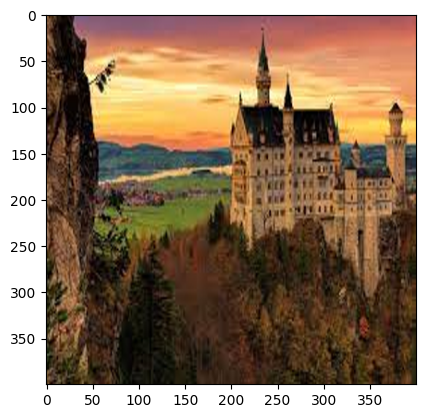

In [15]:
# The content image should be input here with proper name and path
content_image = np.array(Image.open("content.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

### Load the Style Image
Load, reshape and normalize the "style" image (Van Gogh Starry Night painting):

(1, 400, 400, 3)


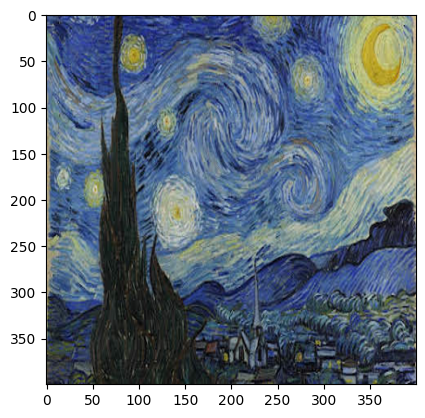

In [16]:
# The style image should be input here with proper name and path
style_image =  np.array(Image.open("style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

### Randomly Initialize the Image to be Generated
Now, we get to initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

(1, 400, 400, 3)


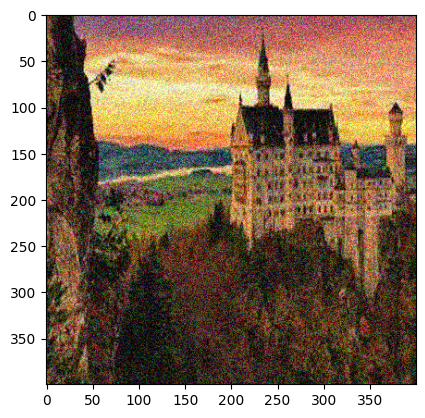

In [17]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

## Load Pre-trained VGG19 Model
This function loads the VGG19 model and returns a list of the outputs for the middle layers.

In [18]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Define the content layer and build the model.

In [19]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [20]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

### Compute Total Cost

#### Compute the Content image Encoding (a_C)

The model has been built, now to compute the content cost, we will encode the content image using the appropriate hidden layer activations. Set this encoding to the variable `a_C`. Later we will need to do the same for the generated image, by setting the variable `a_G` to be the appropriate hidden layer activations. We will use layer `block5_conv4` to compute the encoding. The code below does the following:

1. Set a_C to be the tensor giving the hidden layer activation for layer "block5_conv4" using the content image.

In [21]:
# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

#### Compute the Style image Encoding (a_S)

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [22]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils needed to display the images generated by the style transfer model.

In [23]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

### train_step

Implementing the train_step() function for transfer learning

* Using the Adam optimizer to minimize the total cost `J`.
* Using a learning rate of 0.01
* Within the tf.GradientTape():
   * Compute the encoding of the generated image using vgg_model_outputs. Assign the result to a_G.
   * Compute the total cost J, using the global variables a_C, a_S and the local a_G
   * Use `alpha = 10` and `beta = 40`.

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:

        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, 10, 40)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

### Train the Model

Run the following cell to generate an artistic image. Neural Style Transfer is generally trained using GPUs for fast training.

In [25]:
# Show the generated image at some epochs
generated_image = tf.Variable(generated_image)
epochs = 20000
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

There is actually no error above. I just stopped the training early at 16000 epochs instead of 20000 epochs.

Now, run the following code cell to see the results!

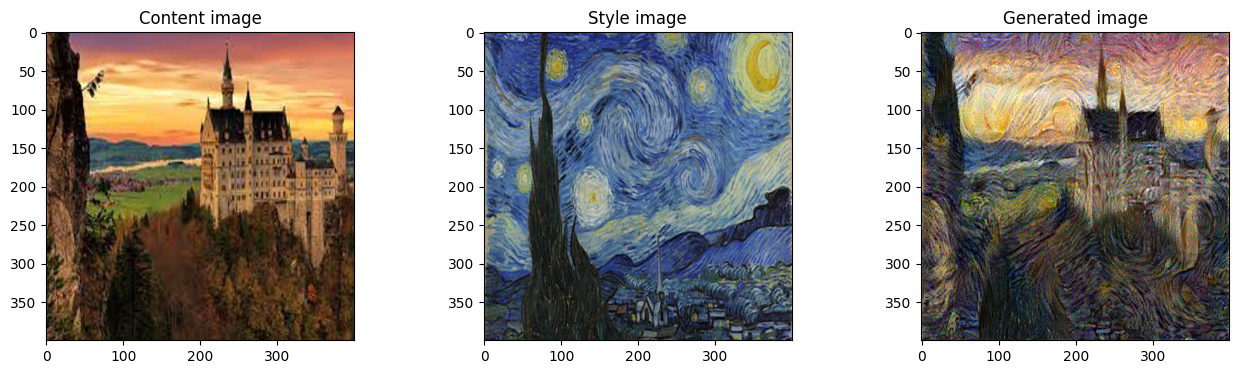

In [26]:
# Show the 3 images in a row for better visualisation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()